### Mathias H. Morgan


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
warnings.filterwarnings('ignore')

In [309]:
stockVolDf = pd.read_csv('A1_stock_volatility_labeled.csv')

# Phase 1: Exploration

In [310]:
stockVolDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13486 entries, 0 to 13485
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       13486 non-null  object 
 1   Open                       13486 non-null  float64
 2   Close                      13486 non-null  float64
 3   High                       13486 non-null  float64
 4   Low                        13486 non-null  float64
 5   Volume                     13486 non-null  int64  
 6   Amount                     13486 non-null  float64
 7   Avg_Price                  13486 non-null  float64
 8   Return                     13486 non-null  float64
 9   Volatility                 13486 non-null  float64
 10  Revenue                    13486 non-null  float64
 11  Net Income                 13486 non-null  float64
 12  Gross Profit               13486 non-null  float64
 13  EPS                        13486 non-null  flo

In [311]:
print("--- Dataset Overview ---")
stockVolDfCoutnt = stockVolDf.shape[0]
print(f"Number of training data rows: {stockVolDfCoutnt:,}")

--- Dataset Overview ---
Number of training data rows: 13,486


In [312]:
print("--- Checking for missing missing values ---\n")
print(f"Missing labels in stockVolDf: \n{stockVolDf.isna().sum()}")

--- Checking for missing missing values ---

Missing labels in stockVolDf: 
Date                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Amount                       0
Avg_Price                    0
Return                       0
Volatility                   0
Revenue                      0
Net Income                   0
Gross Profit                 0
EPS                          0
Total Assets                 0
Total Liabilities            0
Total Equity                 0
Cash and Cash Equivalents    0
Operating Cash Flow          0
Investing Cash Flow          0
Financing Cash Flow          0
Stock                        0
dtype: int64


In [313]:
print("\n--- Checking for empty/whitespace-only reviews ---")
emptyCountTrain = stockVolDf.eq('').sum()
print(f"Number of empty/whitespace-only reviews: {emptyCountTrain}...")


--- Checking for empty/whitespace-only reviews ---
Number of empty/whitespace-only reviews: Date                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Amount                       0
Avg_Price                    0
Return                       0
Volatility                   0
Revenue                      0
Net Income                   0
Gross Profit                 0
EPS                          0
Total Assets                 0
Total Liabilities            0
Total Equity                 0
Cash and Cash Equivalents    0
Operating Cash Flow          0
Investing Cash Flow          0
Financing Cash Flow          0
Stock                        0
dtype: int64...


In [314]:
print("\n--- Checking for duplicate reviews ---")
duplicateRowCount = stockVolDf.duplicated().sum()
print(f"Number of duplicate reviews in test data: {duplicateRowCount}...")


--- Checking for duplicate reviews ---
Number of duplicate reviews in test data: 0...


In [315]:
stockVolDf['Date'] = pd.to_datetime(stockVolDf['Date'])

Transform Target

In [316]:
# Apply log transformation to Volatility
stockVolDf['Volatility_Log'] = np.log1p(stockVolDf['Volatility'])

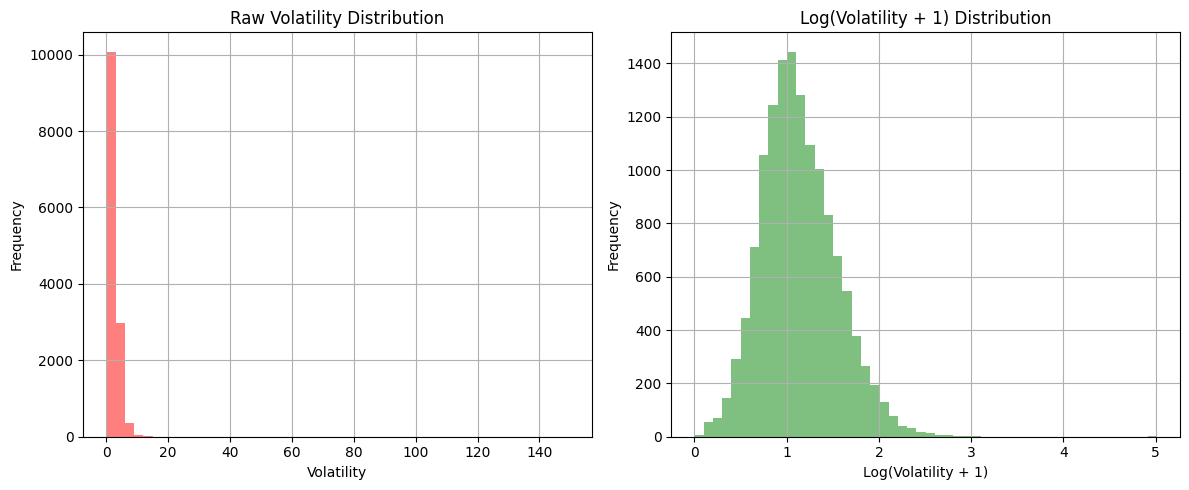

In [317]:
# Visualize distribution before and after
plt.figure(figsize=(12, 5))

# Create pre log-transformation histogram
plt.subplot(1, 2, 1)
stockVolDf['Volatility'].hist(bins=50, alpha=0.5, color='red')
plt.title('Raw Volatility Distribution')
plt.xlabel('Volatility')
plt.ylabel('Frequency')

# Create post log-transformation histogram
plt.subplot(1, 2, 2)
stockVolDf['Volatility_Log'].hist(bins=50, alpha=0.5, color='green')
plt.title('Log(Volatility + 1) Distribution')
plt.xlabel('Log(Volatility + 1)')
plt.ylabel('Frequency')

# Display plots
plt.tight_layout()
plt.show()


In [318]:
print(stockVolDf["Volatility"].describe())

count    13486.000000
mean         2.396125
std          2.033964
min          0.000000
25%          1.345456
50%          1.980023
75%          3.001239
max        149.476478
Name: Volatility, dtype: float64


In [319]:
# Extract month
stockVolDf['month'] = stockVolDf['Date'].dt.month

# Cyclical encoding
stockVolDf['month_sin'] = np.sin(2 * np.pi * stockVolDf['month'] / 12)
stockVolDf['month_cos'] = np.cos(2 * np.pi * stockVolDf['month'] / 12)

# Optional: Drop raw month
stockVolDf = stockVolDf.drop('month', axis=1)

In [ ]:
# 3 lagged features for log volatility
for lag in [1, 2, 3]:
    stockVolDf[f'vol_lag{lag}'] = stockVolDf.groupby('Stock')['Volatility_Log'].shift(lag)

In [321]:
# Features to lag from trading (monthly): Volume, Amount, Return, Volatility_Log
tradingLag = ['Volume', 'Amount', 'Return', 'Volatility_Log']
for col in tradingLag:
    for lag in [1, 2, 3]:  # 1-3 lags for monthly features
        stockVolDf[f'{col}_lag{lag}'] = stockVolDf.groupby('Stock')[col].shift(lag)

In [ ]:
# Features to lag from financial (quarterly): All of them
financialToLag = [
    'Revenue', 'Net Income', 'Gross Profit', 'EPS',
    'Total Assets', 'Total Liabilities', 'Total Equity', 'Cash and Cash Equivalents',
    'Operating Cash Flow', 'Investing Cash Flow', 'Financing Cash Flow']

for col in financialToLag:
    stockVolDf[f'{col}_lag1'] = stockVolDf.groupby('Stock')[col].shift(1)  # 1 lag for quarterly (updates every 3 months)

In [323]:
# Drop rows with NaN in any lagged column (first 3 rows per stock typically)
lagCols = [f'vol_lag{lag}' for lag in [1,2,3]] + [f'{col}_lag{lag}' for col in tradingLag for lag in [1,2,3]] + [f'{col}_lag1' for col in financialToLag]
stockVolDf = stockVolDf.dropna(subset=lagCols).reset_index(drop=True)
print(lagCols)

['vol_lag1', 'vol_lag2', 'vol_lag3', 'Volume_lag1', 'Volume_lag2', 'Volume_lag3', 'Amount_lag1', 'Amount_lag2', 'Amount_lag3', 'Return_lag1', 'Return_lag2', 'Return_lag3', 'Volatility_Log_lag1', 'Volatility_Log_lag2', 'Volatility_Log_lag3', 'Revenue_lag1', 'Net Income_lag1', 'Gross Profit_lag1', 'EPS_lag1', 'Total Assets_lag1', 'Total Liabilities_lag1', 'Total Equity_lag1', 'Cash and Cash Equivalents_lag1', 'Operating Cash Flow_lag1', 'Investing Cash Flow_lag1', 'Financing Cash Flow_lag1']


In [324]:
coltoMove = 'Volatility'
cols = stockVolDf.columns.tolist()
cols.remove(coltoMove)
cols.append(coltoMove)
stockVolDf = stockVolDf[cols]

In [325]:
def separate_feature_target_cols(churnDataFrame: pd.DataFrame) -> tuple[list,str]:
    featureCols = churnDataFrame.columns[:-1] # seperate feature columns
    featureCols = [col for col in featureCols if col not in ['Volatility_Log', 'Date']]
    targetCol = churnDataFrame.columns[-1] # seperate target column
    print(f"All Feature Columns: {featureCols}")
    print(f"Target Column: {targetCol}")
    return featureCols, targetCol

# Separate features and target
featureCols, targetCol = separate_feature_target_cols(stockVolDf)

All Feature Columns: ['Open', 'Close', 'High', 'Low', 'Volume', 'Amount', 'Avg_Price', 'Return', 'Revenue', 'Net Income', 'Gross Profit', 'EPS', 'Total Assets', 'Total Liabilities', 'Total Equity', 'Cash and Cash Equivalents', 'Operating Cash Flow', 'Investing Cash Flow', 'Financing Cash Flow', 'Stock', 'month_sin', 'month_cos', 'vol_lag1', 'vol_lag2', 'vol_lag3', 'Volume_lag1', 'Volume_lag2', 'Volume_lag3', 'Amount_lag1', 'Amount_lag2', 'Amount_lag3', 'Return_lag1', 'Return_lag2', 'Return_lag3', 'Volatility_Log_lag1', 'Volatility_Log_lag2', 'Volatility_Log_lag3', 'Revenue_lag1', 'Net Income_lag1', 'Gross Profit_lag1', 'EPS_lag1', 'Total Assets_lag1', 'Total Liabilities_lag1', 'Total Equity_lag1', 'Cash and Cash Equivalents_lag1', 'Operating Cash Flow_lag1', 'Investing Cash Flow_lag1', 'Financing Cash Flow_lag1']
Target Column: Volatility


In [326]:
# Select only numeric features + target
numericFeatures = [col for col in featureCols if stockVolDf[col].dtype in [np.float64, np.int64]]

# Compute correlation matrix
corrMatrix = stockVolDf[numericFeatures + [targetCol]].corr()
targetCorr = corrMatrix[targetCol].sort_values(ascending=False)

print("Top features positively correlated with Volatility_Log:")
print(targetCorr.head(10))
print("\nTop features negatively correlated with Volatility_Log:")
print(targetCorr.tail(10))

Top features positively correlated with Volatility_Log:
Volatility                  1.000000
Volatility_Log_lag3         0.529781
vol_lag3                    0.529781
Volatility_Log_lag1         0.526397
vol_lag1                    0.526397
Volatility_Log_lag2         0.514145
vol_lag2                    0.514145
Return                      0.199920
Investing Cash Flow         0.072667
Investing Cash Flow_lag1    0.071588
Name: Volatility, dtype: float64

Top features negatively correlated with Volatility_Log:
Gross Profit_lag1        -0.079577
Gross Profit             -0.079769
Revenue_lag1             -0.090385
Revenue                  -0.090673
Total Assets             -0.111249
Total Assets_lag1        -0.111390
Total Liabilities        -0.125903
Total Liabilities_lag1   -0.125929
EPS_lag1                 -0.158972
EPS                      -0.160059
Name: Volatility, dtype: float64


In [327]:
stockVolDf.to_csv('A1_stock_volatility_feature_engineered.csv', index=False)

# Light GBM Model

In [ ]:
# -------------------------- 1. Load --------------------------
trainPath = "A1_stock_volatility_feature_engineered.csv"
submitPath = "A1_stock_volatility_submission.csv"

trainDf = pd.read_csv(trainPath)
submitDf = pd.read_csv(submitPath)

# Categorical
trainDf["Stock"] = trainDf["Stock"].astype("category")
submitDf["Stock"] = submitDf["Stock"].astype("category")

# Feature / target separation
featureCols = [col for col in trainDf.columns if col not in {"Date", "Volatility", "Volatility_Log"}]
targetCol = "Volatility_Log"

# -------------------------- 2. Time-Series Split --------------------------
allDates = sorted(trainDf["Date"].unique())
splitIdx = int(len(allDates) * 0.8)
valDates = set(allDates[splitIdx:])

trainSet = trainDf[~trainDf["Date"].isin(valDates)].copy()
valSet   = trainDf[ trainDf["Date"].isin(valDates)].copy()

xTrain = trainSet[featureCols]
yTrain = trainSet[targetCol]
xVal   = valSet[featureCols]
yVal   = valSet[targetCol]

print(f"Train: {len(trainSet)}, Val: {len(valSet)}")

# -------------------------- 3. Hyperparameter Search --------------------------
paramDist = {
    "n_estimators": [500, 1000],
    "learning_rate": [0.01, 0.03],
    "num_leaves": [64, 128],
    "min_child_samples": [3, 5],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8],
    "reg_alpha": [0, 0.3],
    "reg_lambda": [0, 0.3],
    "max_depth": [-1, 10]
}

tscv = TimeSeriesSplit(n_splits=2)

lgb = LGBMRegressor(
    random_state=42,
    n_jobs=-1,
    categorical_feature="Stock",
    verbose=-1
)

randomSearch = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=paramDist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42
)

randomSearch.fit(xTrain, yTrain)
bestModel = randomSearch.best_estimator_

# -------------------------- 4. Validation  --------------------------
valPredLog  = bestModel.predict(xVal)
valPredReal = np.expm1(valPredLog)
valTrueReal = np.expm1(yVal)
lgbRmse = np.sqrt(mean_squared_error(valTrueReal, valPredReal))

print(f"{'='*50}")
print("\nLIGHTGBM RESULT")
print("="*50)
print(f"Best Params: {randomSearch.best_params_}")
print(f"Validation RMSE: {lgbRmse:.6f}")
print("="*50)

# -------------------------- 5. Volatility Prediction --------------------------
submitDate = "2023-11-01"
submitRows = submitDf[submitDf["Date"] == submitDate].copy()

latestRows = []
for stock in submitRows["Stock"]:
    hist = trainDf[trainDf["Stock"] == stock].sort_values("Date")
    if not hist.empty:
        row = hist.iloc[-1][featureCols].copy()
    else:
        row = trainDf[featureCols].median(numeric_only=True)
        row["Stock"] = stock
    latestRows.append(row)

latestDf = pd.DataFrame(latestRows)
latestDf["Stock"] = latestDf["Stock"].astype("category")
xSubmit = latestDf[featureCols]

predLog = bestModel.predict(xSubmit)
predVol = np.expm1(predLog)

submission = pd.DataFrame({
    "Date":       submitDate,
    "Stock":      submitRows["Stock"].values,
    "Volatility": predVol
}).sort_values("Stock").reset_index(drop=True)

# -------------------------- 6. Results --------------------------
print(submission.head(10))

Train: 9195, Val: 2452
Fitting 2 folds for each of 10 candidates, totalling 20 fits

LIGHTGBM RESULT
Best Params: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 128, 'n_estimators': 1000, 'min_child_samples': 3, 'max_depth': -1, 'learning_rate': 0.03, 'colsample_bytree': 0.7}
Validation RMSE (original scale): 0.792638
         Date Stock  Volatility
0  2023-11-01     A    1.828451
1  2023-11-01   AAL    2.149434
2  2023-11-01   ABG    3.151239
3  2023-11-01   ABT    1.398346
4  2023-11-01   ACA    2.111364
5  2023-11-01  ACCO    2.063188
6  2023-11-01  ACIW    2.396848
7  2023-11-01  ACNT    1.514710
8  2023-11-01   ACU    3.114287
9  2023-11-01   ADP    1.752538


# Cat Boost Model

In [ ]:
# -------------------------- 1. Load --------------------------
trainPath = "A1_stock_volatility_feature_engineered.csv"
submitPath = "A1_stock_volatility_submission.csv"

trainDf = pd.read_csv(trainPath)
submitDf = pd.read_csv(submitPath)

# Categorical
trainDf["Stock"] = trainDf["Stock"].astype("category")
submitDf["Stock"] = submitDf["Stock"].astype("category")

featureCols = [col for col in trainDf.columns if col not in {"Date", "Volatility", "Volatility_Log"}]
targetCol = "Volatility_Log"


# -------------------------- 2. Time-Series Split --------------------------
allDates = sorted(trainDf["Date"].unique())
splitIdx = int(len(allDates) * 0.8)
valDates = set(allDates[splitIdx:])

trainSet = trainDf[~trainDf["Date"].isin(valDates)].copy()
valSet   = trainDf[trainDf["Date"].isin(valDates)].copy()

xTrain = trainSet[featureCols]
yTrain = trainSet[targetCol]
xVal   = valSet[featureCols]
yVal   = valSet[targetCol]

print(f"Train: {len(trainSet)}, Val: {len(valSet)}")

# -------------------------- 3. CatBoost Hyperparameter Search --------------------------
paramDist = {
    "iterations": [500, 1000],
    "learning_rate": [0.01, 0.03],
    "depth": [6, 8, 10],
    "l2_leaf_reg": [1, 3, 5],
    "min_data_in_leaf": [3, 5, 10],
    "bagging_temperature": [0, 0.5, 1]
}

tscv = TimeSeriesSplit(n_splits=2)

catModel = CatBoostRegressor(
    random_state=42,
    thread_count=-1,
    verbose=0,
    cat_features=["Stock"]
)

randomSearch = RandomizedSearchCV(
    estimator=catModel,
    param_distributions=paramDist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42
)

# Fit with early stopping via eval_set
randomSearch.fit(
    xTrain, yTrain,
    eval_set=(xVal, yVal),
    early_stopping_rounds=50,
    verbose=False
)

bestModel = randomSearch.best_estimator_

# -------------------------- 4. Validation --------------------------
valPredLog = bestModel.predict(xVal)
valPredReal = np.expm1(valPredLog)
valTrueReal = np.expm1(yVal)
cbValRmse = np.sqrt(mean_squared_error(valTrueReal, valPredReal))

print(f"{'='*50}")
print(f"CATBOOST REGRESSOR RESULT")
print(f"{'='*50}")
print(f"Best Params: {randomSearch.best_params_}")
print(f"Validation RMSE: {cbValRmse:.6f}")
print(f"{'='*50}")

# -------------------------- 5. Volatility Prediction --------------------------
submitDate = "2023-11-01"
submitRows = submitDf[submitDf["Date"] == submitDate].copy()

latestRows = []
for stock in submitRows["Stock"]:
    hist = trainDf[trainDf["Stock"] == stock].sort_values("Date")
    if not hist.empty:
        row = hist.iloc[-1][featureCols].copy()
    else:
        row = trainDf[featureCols].median(numeric_only=True)
        row["Stock"] = stock
    latestRows.append(row)

latestDf = pd.DataFrame(latestRows)
latestDf["Stock"] = latestDf["Stock"].astype("category")
xSubmit = latestDf[featureCols]

predLog = bestModel.predict(xSubmit)
predVol = np.expm1(predLog)

submission = pd.DataFrame({
    "Date": submitDate,
    "Stock": submitRows["Stock"].values,
    "Volatility": predVol
}).sort_values("Stock").reset_index(drop=True)

# -------------------------- 6. Results --------------------------
outPath = "A1_stock_volatility_submission.csv"
submission.to_csv(outPath, index=False)
print(f"\nSubmission saved → {outPath}")
print(submission.head(10))

Train: 9195, Val: 2452
Fitting 2 folds for each of 10 candidates, totalling 20 fits
CATBOOST REGRESSOR RESULT
Best Params: {'min_data_in_leaf': 10, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 6, 'bagging_temperature': 0.5}
Validation RMSE: 0.756457
         Date Stock  Volatility
0  2023-11-01     A    1.687663
1  2023-11-01   AAL    2.077502
2  2023-11-01   ABG    2.753358
3  2023-11-01   ABT    1.128033
4  2023-11-01   ACA    1.653580
5  2023-11-01  ACCO    1.846614
6  2023-11-01  ACIW    2.278468
7  2023-11-01  ACNT    1.426962
8  2023-11-01   ACU    2.793594
9  2023-11-01   ADP    1.289542

Submission saved → A1_stock_volatility_submission.csv
         Date Stock  Volatility
0  2023-11-01     A    1.687663
1  2023-11-01   AAL    2.077502
2  2023-11-01   ABG    2.753358
3  2023-11-01   ABT    1.128033
4  2023-11-01   ACA    1.653580
5  2023-11-01  ACCO    1.846614
6  2023-11-01  ACIW    2.278468
7  2023-11-01  ACNT    1.426962
8  2023-11-01   ACU    2.79359

# Random Forest Model

In [ ]:
# -------------------------- 1. Load --------------------------
trainPath = "A1_stock_volatility_feature_engineered.csv"
submitPath = "A1_stock_volatility_submission.csv"

trainDf = pd.read_csv(trainPath)
submitDf = pd.read_csv(submitPath)

# Categorical
trainDf["Stock"] = trainDf["Stock"].astype("category")
submitDf["Stock"] = submitDf["Stock"].astype("category")

featureCols = [col for col in trainDf.columns if col not in {"Date", "Volatility", "Volatility_Log"}]
targetCol = "Volatility_Log"

categoricalCols = ["Stock"]
numericCols = [col for col in featureCols if col not in categoricalCols]

# -------------------------- 2. Time-Series Split --------------------------
allDates = sorted(trainDf["Date"].unique())
splitIdx = int(len(allDates) * 0.8)
valDates = set(allDates[splitIdx:])

trainSet = trainDf[~trainDf["Date"].isin(valDates)].copy()
valSet   = trainDf[ trainDf["Date"].isin(valDates)].copy()

xTrainRaw = trainSet[featureCols]
yTrain = trainSet[targetCol]
xValRaw = valSet[featureCols]
yVal = valSet[targetCol]

print(f"Train: {len(trainSet)}, Val: {len(valSet)}")

# -------------------------- 3. Preprocessing --------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numericCols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categoricalCols)
    ]
)

xTrain = preprocessor.fit_transform(xTrainRaw)
xVal = preprocessor.transform(xValRaw)

# -------------------------- 4. Random Forest Hyperparameter Search --------------------------
paramDist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["sqrt", 0.7, 0.9],
    "bootstrap": [True, False]
}

tscv = TimeSeriesSplit(n_splits=2)

rfModel = RandomForestRegressor(random_state=42, n_jobs=-1)

randomSearch = RandomizedSearchCV(
    estimator=rfModel,
    param_distributions=paramDist,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    verbose=1,
    random_state=42
)

randomSearch.fit(xTrain, yTrain)
bestModel = randomSearch.best_estimator_

# -------------------------- 5. Validation --------------------------
valPredLog = bestModel.predict(xVal)
valPredReal = np.expm1(valPredLog)
valTrueReal = np.expm1(yVal)
rfValRmse = np.sqrt(mean_squared_error(valTrueReal, valPredReal))

print(f"{'='*50}")
print(f"RANDOM FOREST REGRESSOR RESULT")
print(f"{'='*50}")
print(f"Best Params: {randomSearch.best_params_}")
print(f"Validation RMSE: {rfValRmse:.6f}")
print(f"{'='*50}")

# -------------------------- 7. Volatility Prediction --------------------------
submitDate = "2023-11-01"
submitRows = submitDf[submitDf["Date"] == submitDate].copy()

latestRows = []
for stock in submitRows["Stock"]:
    hist = trainDf[trainDf["Stock"] == stock].sort_values("Date")
    if not hist.empty:
        row = hist.iloc[-1][featureCols].copy()
    else:
        # Safe fallback: median of numeric + known Stock
        row = trainDf[numericCols].median(numeric_only=True).to_dict()
        row["Stock"] = stock
        # Add any missing categorical/numeric cols with 0 or NaN
        for col in featureCols:
            if col not in row:
                row[col] = 0 if col in numericCols else stock
    latestRows.append(row)

latestDf = pd.DataFrame(latestRows)
latestDf["Stock"] = latestDf["Stock"].astype("category")

# Ensure all feature columns exist
for col in featureCols:
    if col not in latestDf.columns:
        latestDf[col] = 0

xSubmit = preprocessor.transform(latestDf[featureCols])

predLog = bestModel.predict(xSubmit)
predVol = np.expm1(predLog)

submission = pd.DataFrame({
    "Date": submitDate,
    "Stock": submitRows["Stock"].values,
    "Volatility": predVol
}).sort_values("Stock").reset_index(drop=True)

# -------------------------- 8. Results --------------------------
print(submission.head(10))

Train: 9195, Val: 2452
Fitting 2 folds for each of 10 candidates, totalling 20 fits
RANDOM FOREST REGRESSOR RESULT
Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.9, 'max_depth': 20, 'bootstrap': True}
Validation RMSE: 0.853893
         Date Stock  Volatility
0  2023-11-01     A    1.403625
1  2023-11-01   AAL    1.866632
2  2023-11-01   ABG    2.274611
3  2023-11-01   ABT    0.888344
4  2023-11-01   ACA    1.536174
5  2023-11-01  ACCO    1.725243
6  2023-11-01  ACIW    1.918392
7  2023-11-01  ACNT    1.435771
8  2023-11-01   ACU    2.948300
9  2023-11-01   ADP    1.130123


In [ ]:
# RMSE Result Summary
print("\n--- RMSE Summary ---")
print(f"LIGHTGBM RMSE: {lgbRmse:.6f}")
print(f"CATBOOST RMSE: {cbValRmse:.6f}")
print(f"RANDOM FOREST RMSE: {rfValRmse:.6f}")


--- RMSE Summary ---
LIGHTGBM RMSE: 0.792638
CATBOOST RMSE: 0.756457
RANDOM FOREST RMSE: 0.853893


# References

https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/

https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0